# The Prediction of Nuclear Magnetic Resonance (NMR) Spectroscopy on a Quantum Computer

This tutorial demonstrates how to simulate liquid‑state 1H NMR spectra of small organic molecules using Qiskit. We map a spin Hamiltonian to qubit operators, perform trotterized time evolution, evaluate transverse magnetization with Estimator primitives, and recover the frequency‑domain spectrum via a Fourier transform. As a concrete example, we study the molecule *cis‑3‑chloroacrylic acid* 


<div style="display:flex; gap:12px; align-items:flex-start;">
  <img src="10_qiskit_files/images/bmse000368.png"  alt="Figure A" style="height:260px; width:auto; object-fit:contain;">
  <img src="10_qiskit_files/images/bmse000368_s.png" alt="Figure B" style="height:260px; width:auto; object-fit:contain;">
</div>

The cis-3-chloroacrylic acid molecule has a total of three hydrogen atoms, represented by the molecular formula ($C_3H_3ClO_2$). One of these hydrogens is part of the acidic -OH group in the -CO2H moiety; in standard NMR experiments, this hydrogen undergoes exchange with the D2O solvent and is typically not detected. The two hydrogens that are observed in the NMR spectrum are the vinylic hydrogens located on the carbon-carbon double bond. Since these two hydrogens are adjacent to each other across the double bond, they produce two distinct signals in the $^{1}H$ NMR spectrum, which split each other due to their coupling interactions. 

## What you will do
- Load the cis-3‑chloroacrylic acid spin Hamiltonian in struqture format
- Transformation to rotating frame
- Conver the NMR Hamiltonian to Qiskit’s *SparsePauliOp*.
- Construct first‑order (and optionally higher‑order) Trotter circuits for time evolution.
- Use Estimator V2 (Qiskit 2.2.x) with a statevector backend to obtain expectation values of magnetization.
- Compute the NMR spectrum from time‑domain signals
- Preform Fourier transformation and compare against a reference spectrum

## Where to find more information

 - In the documentation of [HQS Spectrum Tools](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/index.html) you can find the derivation of the 1D NMR spectrum.
 
  - The derivation of the NMR spectrum on a quantum computer is described in the paper: 
    - A. Khedri et al.,  *The impact of noise on the simulation of NMR spectroscopy on NISQ devices*, [arXiv:2404.18903](https://arxiv.org/abs/2404.18903) (2024)
 - The notebook demonstrate the calculate of the NMR spectrum of *cis‑3‑chloroacrylic acid*. Many more molecule are available on HQStage in the package [HQS NMR Parameters](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database/molecular_data.html) which is part of HQS Spectrum Tools. 

In [1]:
# Run this cell once to install the required packages for local/Aer simulation.
# Notes:
# - ipykernel is optional; install it if you want this environment as a Jupyter kernel.

%pip install -q "qiskit>=2.2,<3" struqture_py numpy scipy matplotlib ipykernel

Note: you may need to restart the kernel to use updated packages.


In [2]:
from struqture_py.spins import PauliHamiltonian
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

# NEW imports for Qiskit 2.2.x
from qiskit.primitives import StatevectorEstimator as Estimator

import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path
import pickle
from typing import Tuple, Any

## 1. NMR Hamiltonian


The NMR Hamiltonian is
$$
\hat H \;=\; -\sum_{\ell}\gamma_\ell\!\left(1+\delta_\ell\right) B_z\, \hat I_\ell^{\,z}
\;+\; 2\pi \sum_{k<\ell} J_{k\ell}\; \hat{\mathbf I}_k \!\cdot\! \hat{\mathbf I}_\ell,
\qquad
\hat{\mathbf I}_k \!\cdot\! \hat{\mathbf I}_\ell = \hat I_k^{\,x}\hat I_\ell^{\,x}+\hat I_k^{\,y}\hat I_\ell^{\,y}+\hat I_k^{\,z}\hat I_\ell^{\,z}.
$$

The parameters of the Hamiltonian are:

- $\gamma_l$: gyromagnetic ratio (rad·s⁻¹·T⁻¹). For ¹H, $\gamma/2\pi$ ≈ 42.577 MHz/T.
- $\delta_l$: chemical shift (dimensionless). Typically reported in ppm.
- $B_z$: static magnetic field along z (T).
- $J_{kl}$: isotropic scalar coupling between spins $k$ and $l$ (Hz).
- $I^\alpha_k$: dimensionless spin operators ($\alpha \in {x, y, z}$)
- $\omega_l$: shifted Larmor angular frequency


This notebook loads the liquid‑state spin Hamiltonian of the molecule *cis-3-chloroacrylic_acid_exp* at a static magnetic field \(B_0 = 11.7433\) T applied along the z direction. The Hamiltonian is stored as JSON produced by `struqture_py` (see also the documentation of [struqture](https://hqsquantumsimulations.github.io/struqture/)).



At the end of the following cell, we print the `PauliHamiltonian`. The terms in `struqture` mean:

- The object is a sparse sum of Pauli strings with real coefficients. A key like `0Z`, `1Z`, or `0X1X` identifies which Pauli operator acts on which spin index:
  - `iZ` means a Z operator on spin $i=0,1$.
  - `0X1X` means X on spin 0 and X on spin 1 (tensor product $X \otimes X$). Similarly, `0Y1Y` and `0Z1Z` are $Y \otimes Y$ and $Z \otimes Z$ between spins 0 and 1.



In [3]:
# Folder that contains the Hamiltonian JSON files.
data_dir = Path("10_qiskit_files")

# Name of the molecule.
molecule_name = "bmse000368"

# Magnetic field
field_T = 11.7433

# Build full filename.
filename = data_dir / f"{molecule_name}_B{field_T}T.json"

# Open JSON file.
with open(filename, "r") as json_file:
    hamiltonian_json = json.load(json_file)

# Create PauliHamiltonian from JSON file.
hamiltonian_struqture = PauliHamiltonian.from_json(hamiltonian_json)

# Get the number of spins in the Hamiltonian.
number_spins = hamiltonian_struqture.current_number_spins()

# Note that the energies of 0Z and 1Z and 2 to 3 orders of magnetic larger than the coupling.
print("Struqture Hamiltonian:\n", hamiltonian_struqture)

Struqture Hamiltonian:
 PauliHamiltonian{
0Z: -9.900257858037949e3,
1Z: -1.0014548997163773e4,
0X1X: 1.2030758912052322e1,
0Y1Y: 1.2030758912052322e1,
0Z1Z: 1.2030758912052322e1,
}


## 2. Rotating-frame shift: subtracting the mean Z term

After executing the previous cell, we noted that the energies in Hamiltonian differ by 2-3 orders of magnitude. This is problematic when doing a Trotterized time-evolution on a quantum computer. We there perform a transofmraiton to the rotating frame. 

In [4]:
# We are now extracting the single-qubit Z terms from the full Hamiltonian:
z_couplings = []
for i in range(number_spins):
    z_couplings.append(hamiltonian_struqture.get(f"{i}Z"))

# Mean of Z terms.
mean_z_parameter = np.mean(z_couplings)

# Setting the chemical shift due to rotating frame of the QC calculation:
chemical_shift_hz = mean_z_parameter / (2 * np.pi)

# We now subtract the mean value of the Z coupling from the full Hamiltonian
# to arrive at the Hamiltonian that is used in the NMR calculation and store the second
# chemical shift we need to apply to the spectrum at the end.
correction_hamiltonian = PauliHamiltonian()
for i in range(number_spins):
    correction_hamiltonian.set(f"{i}Z", mean_z_parameter)

hamiltonian_struqture = hamiltonian_struqture - correction_hamiltonian

# In the rotating frame, the energies are all of order 1.
print("Hamiltonian in rotating frame: \n", hamiltonian_struqture)

Hamiltonian in rotating frame: 
 PauliHamiltonian{
0Z: 5.714556956291199e1,
1Z: -5.714556956291199e1,
0X1X: 1.2030758912052322e1,
0Y1Y: 1.2030758912052322e1,
0Z1Z: 1.2030758912052322e1,
}


## 3. Convert Struqture Hamiltonian to Qiskit

In [5]:
def struqture_hamiltonian_to_qiskit_op(
    ham_struqture: PauliHamiltonian, n_qubits: int
) -> SparsePauliOp:
    """Converts struqture-style Pauli strings ("iXjZ") to Qiskit format ("XZ",[i,j]).

    Args:
        struqture_input: String or list of strings in struqture format.
        n_qubits: Total number of qubits.

    Returns:
        Qiskit-style Pauli string or list of such strings.
    """

    def convert_single(s: str) -> str:
        pauli_vec = ["I"] * n_qubits
        if s != "I":
            for i in range(0, len(s), 2):
                idx = int(s[i])
                op = s[i + 1]
                pauli_vec[n_qubits - idx - 1] = op
        return "".join(pauli_vec)

    pauli_strs = []
    coeffs = []
    for key, val in zip(ham_struqture.keys(), ham_struqture.values()):
        s = str(key)
        p = convert_single(s)
        pauli_strs.append(p)
        coeffs.append(complex(val))

    return SparsePauliOp(pauli_strs, coeffs)

In [6]:
hamiltonian_qiskit = struqture_hamiltonian_to_qiskit_op(hamiltonian_struqture, number_spins)

# Qiskit representation of the Hamiltonian.
print("Hamiltonian in Qiskit:\n", hamiltonian_qiskit)

Hamiltonian in Qiskit:
 SparsePauliOp(['IZ', 'ZI', 'XX', 'YY', 'ZZ'],
              coeffs=[ 57.14556956+0.j, -57.14556956+0.j,  12.03075891+0.j,  12.03075891+0.j,
  12.03075891+0.j])


## 4. Quantum circuit for Trotterized time evolution

Here we build a Trotter circuit that generates the time dependence needed for the transverse response. To follow a detailed derivation: 
 - Derivation of the correlator can be found at the [documentation of the HQS Spectrum Tools](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/background/math.html). 
 - A. Khedri et al., *The impact of noise on the simulation of NMR spectroscopy on NISQ devices*, [arXiv:2404.18903](https://arxiv.org/abs/2404.18903)

We start from  correlator (a small transverse pulse on site $l$, readout on site $k$):
$$
\big\langle \gamma_k\, \hat I_k^{x} \big\rangle (t) \;\propto\; \mathrm{Tr}\!\left( \hat I_k^{x}\, e^{-i \hat H t}\, \hat I_{\ell}^{y}\, e^{+i \hat H t} \right).
$$

After moving to the rotating frame (subtracting the mean Zeeman term) and summing over sites, the required correlators are
$$
C_{xx}(t) \;=\; \mathrm{Tr}\!\big( \hat I_{x}^{\rm tot}(t)\, \hat I_x^{\rm tot}(0)\big), 
\qquad
C_{yx}(t) \;=\; \mathrm{Tr}\!\big( \hat I_{y}^{\rm tot}(t)\, \hat I_x^{\rm tot}(0)\big).
$$

A useful eigenstate expansion (using eigenstates of $ \hat I_x^{\rm tot} $) is
\begin{equation}
\mathrm{Tr}\!\big( \hat I_{x/y}^{\rm tot}(t)\, \hat I_x^{\rm tot}(0)\big)
\;=\;
\sum_{n} m_{x,n}(0)\, \langle m_{x,n}(t)\,|\, \hat I_{x/y}^{\rm tot}\,|\, m_{x,n}(t)\rangle,
\end{equation}
where $ m_{x,n}(0) $ are the initial eigenvalues of $ \hat I_x^{\rm tot} $. For two spins, symmetry leaves only one relevant initial state (the $ |{+}{+}\rangle_x $ sector).

On a quantum computer we then have to do the following steps:
- Prepare an eigenstate of $ \hat I_x^{\rm tot} $ with positive magnetization (e.g., $ |{+}{+}\rangle_x $ for two spins).
- Evolve under the rotating‑frame Hamiltonian using a Trotterized unitary $ U(\Delta t)=e^{-i \hat H \Delta t} $ and repeat for $ N $ steps.
- At each step, estimate $ \langle \hat I_x^{\rm tot}(t)\rangle $ and $ \langle \hat I_y^{\rm tot}(t)\rangle $ (e.g., with Estimator V2), forming $ C_{xx}(t) $ and $ C_{yx}(t) $.
- Apply a mild damping/window and Fourier transform; shift the frequency axis by $ -\bar\omega $ to obtain the spectrum.

The following cells show to perform these steps.

### 4.1 Trotter circuit

In [7]:
number_of_trottersteps = 100
trotter_timestep = 0.01

# Trotter Circuit
trotter_step_first_order = PauliEvolutionGate(
    hamiltonian_qiskit, trotter_timestep, synthesis=LieTrotter()
)

circuit = QuantumCircuit(hamiltonian_qiskit.num_qubits)
circuit.append(trotter_step_first_order, range(hamiltonian_qiskit.num_qubits))
circuit = circuit.decompose(reps=1)

print("Trotter circuit: \n", circuit)

Trotter circuit: 
       ┌────────────┐┌───────────────┐┌───────────────┐              
q_0: ─┤ Rz(1.1429) ├┤0              ├┤0              ├─■────────────
     ┌┴────────────┤│  Rxx(0.24062) ││  Ryy(0.24062) │ │ZZ(0.24062) 
q_1: ┤ Rz(-1.1429) ├┤1              ├┤1              ├─■────────────
     └─────────────┘└───────────────┘└───────────────┘              


### 4.2 Observables

To reconstruct the spectrum in the rotating frame, we need the transverse magnetization in both $x$ and $y$ directions. Total transverse operators
$$
\hat I_{x/y}^{\rm tot}=\sum_k \hat I_k^{\,x/y}
$$
What we record each time step is
$
\langle \hat I_x^{\rm tot}(t)\rangle 
$
and 
$
\langle \hat I_y^{\rm tot}(t)\rangle \, .
$

These two signals provide the correlators used in the Fourier transform ($C_{xx}(t) $ and $C_{yx}(t)$ ).

In [8]:
obs_x = SparsePauliOp.from_sparse_list(
    [("X", [i], 1.0) for i in range(number_spins)], num_qubits=number_spins
)
obs_y = SparsePauliOp.from_sparse_list(
    [("Y", [i], 1.0) for i in range(number_spins)], num_qubits=number_spins
)

### 4.3 Initial state

From Eq. (1) we also know that we have to initialize the state as an eigenstate of $I_{x}$ operator. We can do this by a rotation of $\pi / 2$ around the $y$-axis, or alternatively, apply a Hadamard gate.

In [9]:
initial_circuit = QuantumCircuit(hamiltonian_qiskit.num_qubits)
for i in range(hamiltonian_qiskit.num_qubits):
    initial_circuit.ry(0.5 * np.pi, i)

### 4.4 Simulation with Qiskit's *Estimator*

In this step we use one of the backends in qiskit to perform a the trotterzed time-evolution and find the time dependence of total magnetization for our system of interest.

In [10]:
number_of_initializations = 1
# Build the estimator ONCE, outside loops (no backend needed for pure statevector)
estimator = Estimator()

full_circuit = QuantumCircuit(hamiltonian_qiskit.num_qubits)
full_circuit = full_circuit.compose(initial_circuit)


exp_Sz_total = np.zeros((number_of_initializations, number_of_trottersteps))
exp_Sy_total = np.zeros((number_of_initializations, number_of_trottersteps))
times = []

for m in range(number_of_initializations):
    for n in range(number_of_trottersteps):
        if n > 0:
            full_circuit = full_circuit.compose(circuit)

        # V2 primitive call: a list of PUBs [(circuit, observables, <optional params>)]
        job = estimator.run([(full_circuit, [obs_x, obs_y])])
        pub_result = job.result()[0]  # PubResult
        evs = pub_result.data.evs  # expectation values array-like

        exp_Sz_total[m, n] = evs[0]
        exp_Sy_total[m, n] = evs[1]

        if m == 0:
            times.append(n * trotter_timestep)

Above we calculate the expectation value for every spins. Now we have to sum over all spins. Additionally we add $0$ to increae the resolution of the spectrum.

\begin{equation*}
\mathrm{Tr}\!\big( \hat I_{x/y}^{\rm tot}(t)\, \hat I_x^{\rm tot}(0)\big)
\;=\;
\sum_{n} m_{x,n}(0)\, \langle m_{x,n}(t)\,|\, \hat I_{x/y}^{\rm tot}\,|\, m_{x,n}(t)\rangle,
\end{equation*}

In [11]:
noise_strength = 5.0
noise_decay = np.exp(-noise_strength * np.array(times))
exp_Sz_total = exp_Sz_total[0:number_of_initializations, :] * noise_decay
exp_Sy_total = exp_Sy_total[0:number_of_initializations, :] * noise_decay

padding = 0
exp_Sz_total = np.pad(exp_Sz_total, ((0, 0), (0, padding)), mode="constant", constant_values=0)
exp_Sy_total = np.pad(exp_Sy_total, ((0, 0), (0, padding)), mode="constant", constant_values=0)

# Calculate the norm.
S0 = exp_Sz_total[0]
norm = np.sum(S0)

# Correlators.
c_xx = np.zeros(number_of_trottersteps + padding)
c_yx = np.zeros(number_of_trottersteps + padding)

# Perform vectorized calculations
for i in range(number_of_trottersteps + padding):
    c_xx[i] = np.sum(S0 * exp_Sz_total[:, i], axis=0) / (2 * norm)
    c_yx[i] = np.sum(S0 * exp_Sy_total[:, i], axis=0) / (2 * norm)

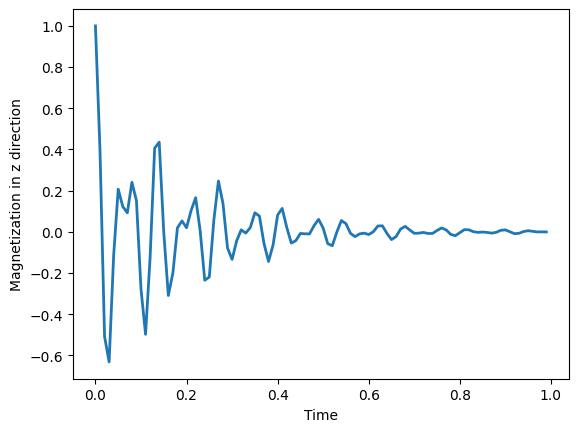

In [12]:
plt.figure(dpi=100)
plt.plot(times, c_xx, color="C0", lw=2.0)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Magnetization in z direction", fontsize=10)
plt.show()

## 5. Finding the Spectrum

In this step, we perform a Fourier transform of the correlation functions to find the spectrum (a detailed derivation fo the spectral function can be found in the paper [arXiv:2404.18903](https://arxiv.org/abs/2404.18903))

$$
S(\omega)
\;=\;
\,\mathrm{Re}\!\int_{0}^{\infty} \! dt\; e^{-i(\omega-\bar\omega)t - \Gamma t}\,
\mathrm{Tr} \left( \hat I_x^{\rm tot}(t)\,\hat I_x^{\rm tot}(0) \right)
\;-\;
\,\mathrm{Im}\!\int_{0}^{\infty} \! dt\; e^{-i(\omega-\bar\omega)t - \Gamma t}\,
\mathrm{Tr} \left( \hat I_y^{\rm tot}(t)\,\hat I_x^{\rm tot}(0) \right).
$$

where $\Gamma$ is the effective decoherence rate that physically arises due to the interaction of nuclear spin with its environment or simply an artificial decay to perform the Fourier transform.

In [13]:
def time_correlator_to_spectrum(
    m_avg_z: np.ndarray,
    m_avg_y: np.ndarray,
    trotter_timestep: float,
    number_of_trottersteps: int,
    Hz_to_ppm_conversion: float,
    chem_shift_hz: float,
) -> Tuple[np.ndarray[Any, Any], np.ndarray[Any, Any]]:
    """Calculate the full spectrum from the computed correlators via a Fourier Transform.

    Args:
        m_avg_z (np.ndarray): The first correlator (e.g., the ZZ correlator if the field
            is in the x-direction).
        m_avg_y (np.ndarray): The second correlator (e.g., the YZ correlator if the field
            is in the x-direction).
        N_max (int): Number of Trotter steps.
        trotter_timestep (float): The Trotter timestep.
        Hz_to_ppm_conversion (float): Conversion factor from frequency to ppm.
        chem_shift_hz (float): The chemical shift of the input Hamiltonian (in Hz).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - **spectrum_full (np.ndarray):** The calculated spectrum.
            - **ppm (np.ndarray):** The ppm array to plot the full spectrum against.
    """
    spectrum_full = np.zeros(m_avg_z.shape[0], dtype=np.float64)

    m_avg_z = fft_causal(m_avg_z)
    m_avg_y = fft_causal(m_avg_y)

    frequencies = np.fft.fftshift(np.fft.fftfreq(number_of_trottersteps, d=trotter_timestep))

    # And now we have the frequency axis in ppm:
    # we need to shift the frequencies by twice the chemical input shift and then by the reference
    # energy, i.e. the energy of the homoisotope (H) times the magnetic field.
    ppm = (frequencies - 2 * chem_shift_hz) * Hz_to_ppm_conversion

    spectrum_full = m_avg_z.real + m_avg_y.imag

    spectrum_full /= np.max(np.abs(spectrum_full))

    return np.abs(spectrum_full), ppm


def fft_causal(f: np.ndarray) -> np.ndarray:
    """
    Performs the Fourier Transform of a causal signal by separating its even and odd parts.

    Args:
        f (np.ndarray): Input causal signal.

    Returns:
        np.ndarray: The complex Fourier Transform of the causal signal.
    """
    L = len(f)

    # Even part (symmetrize)
    fe = np.zeros(2 * L - 1, dtype=f.dtype)
    fe[:L] = f
    fe[L:] = f[:-1][::-1]
    fe /= 2

    # Odd part (antisymmetrize)
    fo = np.zeros(2 * L - 1, dtype=f.dtype)
    fo[:L] = f
    fo[L:] = -f[:-1][::-1]
    fo /= 2
    fo[0] = 0  # Avoids jump discontinuity at t=0

    # FFT with orthogonal normalization and shift
    fft_even = np.fft.fftshift(np.fft.fft(fe, norm="ortho"))
    fft_odd = np.fft.fftshift(np.fft.fft(fo, norm="ortho"))

    # Combine and downsample to original length
    combined_fft = (fft_even + fft_odd)[::2]

    return combined_fft

In [14]:
# Gyromagnetic ratio for 1H.
GYROMAGNETIC_RATIO_1H_RAD_S_T = 267_522_128.0

# Larmor/reference frequency in Hz at the given field.
reference_energy_hz = GYROMAGNETIC_RATIO_1H_RAD_S_T * field_T / (2 * np.pi)

# Conversion factor to go from Hz to ppm at this field: ppm = (Hz) * (1e6 / v0)
Hz_to_ppm_conversion = 1e6 / reference_energy_hz

In [15]:
spectrum_full, ppm = time_correlator_to_spectrum(
    c_xx,
    c_yx,
    trotter_timestep + padding,
    number_of_trottersteps,
    Hz_to_ppm_conversion=Hz_to_ppm_conversion,
    chem_shift_hz=chemical_shift_hz,
)

Reading off the known spectrum obtained via exact diagonalization from json file. You can also use *HQS Spectrum Tools* to calculate the spectrum.

In [16]:
with open(data_dir / "hqs_spectrum_tools_bmse000368_B11.7433T.pkl", "rb") as f:
    hqs_spectrum_tools_results = pickle.load(f)

hqs_spectrum_tools_ppm = hqs_spectrum_tools_results["frequencies"]
hqs_spectrum_tools_spectrum = hqs_spectrum_tools_results["spectrum"]
hqs_spectrum_tools_spectrum /= np.max(np.abs(hqs_spectrum_tools_spectrum))

Comparing the simulated spectrum with known results.

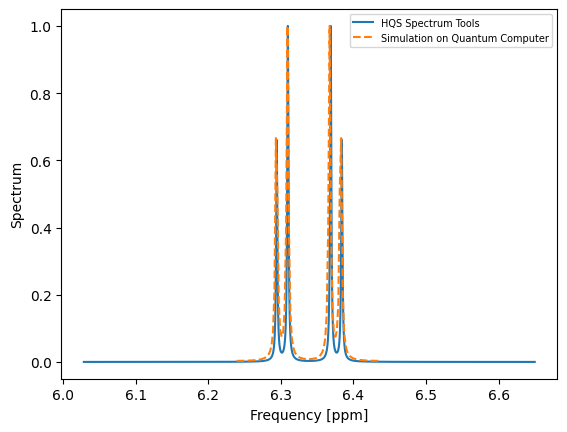

In [17]:
plt.figure(dpi=100)
plt.plot(
    hqs_spectrum_tools_ppm, hqs_spectrum_tools_spectrum, color="C0", label="HQS Spectrum Tools"
)
plt.plot(ppm, spectrum_full, color="C1", ls="--", label="Simulation on Quantum Computer")

plt.xlabel("Frequency [ppm]")
plt.ylabel("Spectrum")
plt.legend(fontsize=7)
plt.show()